In [1]:
import warnings
warnings.filterwarnings('ignore')

from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from statsforecast.utils import AirPassengersDF
from utilsforecast.plotting import plot_series

import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf


plt.rcParams['figure.figsize'] = (18, 7)

In [13]:
df = AirPassengersDF
from utilsforecast.data import generate_series

# df = generate_series(2, freq='MS')
df

,unique_id,ds,y
0,1.0,1949-01-31,112.0
1,1.0,1949-02-28,118.0
2,1.0,1949-03-31,132.0
3,1.0,1949-04-30,129.0
4,1.0,1949-05-31,121.0
...,...,...,...
139,1.0,1960-08-31,606.0
140,1.0,1960-09-30,508.0
141,1.0,1960-10-31,461.0
142,1.0,1960-11-30,390.0


In [16]:

sf = StatsForecast(
    models = [AutoARIMA(season_length = 12)],
    freq = 'ME'
)

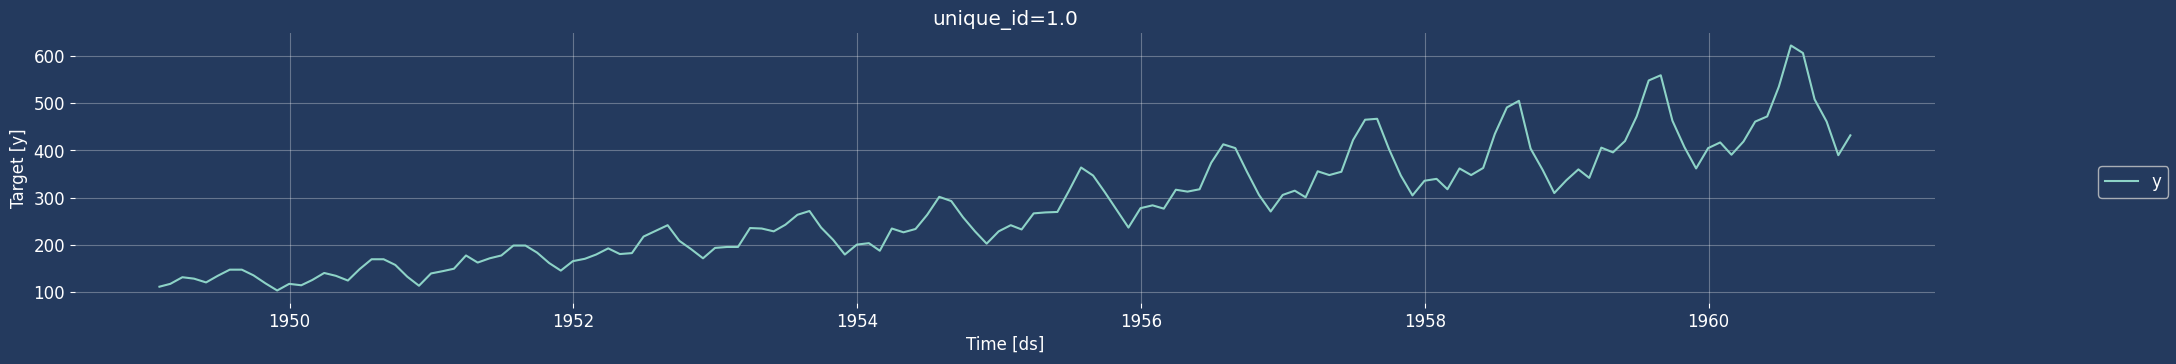

In [17]:
import matplotlib.pyplot as plt

# Define the dark style with a dark blue background
dark_style = {
    'figure.facecolor': '#243A5E',    # Dark blue background
    'axes.facecolor': '#243A5E',      # Dark blue background for plot area
    'text.color': 'white',            # White text
    'axes.labelcolor': 'white',       # White labels
    'xtick.color': 'white',           # White ticks
    'ytick.color': 'white',           # White ticks
    'font.size': 12,
    'axes.spines.left': False,        # Remove left spine
    'axes.spines.right': False,       # Remove right spine
    'axes.spines.top': False,         # Remove top spine
    'axes.spines.bottom': False,      # Remove bottom spine
           # Enable grid
    'grid.color': 'white',            # White grid lines
    'grid.alpha': 0.3,                # Semi-transparent grid
}


# Apply the style
plt.rcParams.update(dark_style)

# Choose a colormap that contrasts well with dark blue
palette = 'Set3'  # or 'Pastel1', 'Set1', 'Set3'

# Now use this string name in your plot_series function
plot_series(df, palette=palette)

Savitzky-Golay window size: 11
Moving average window size: 14


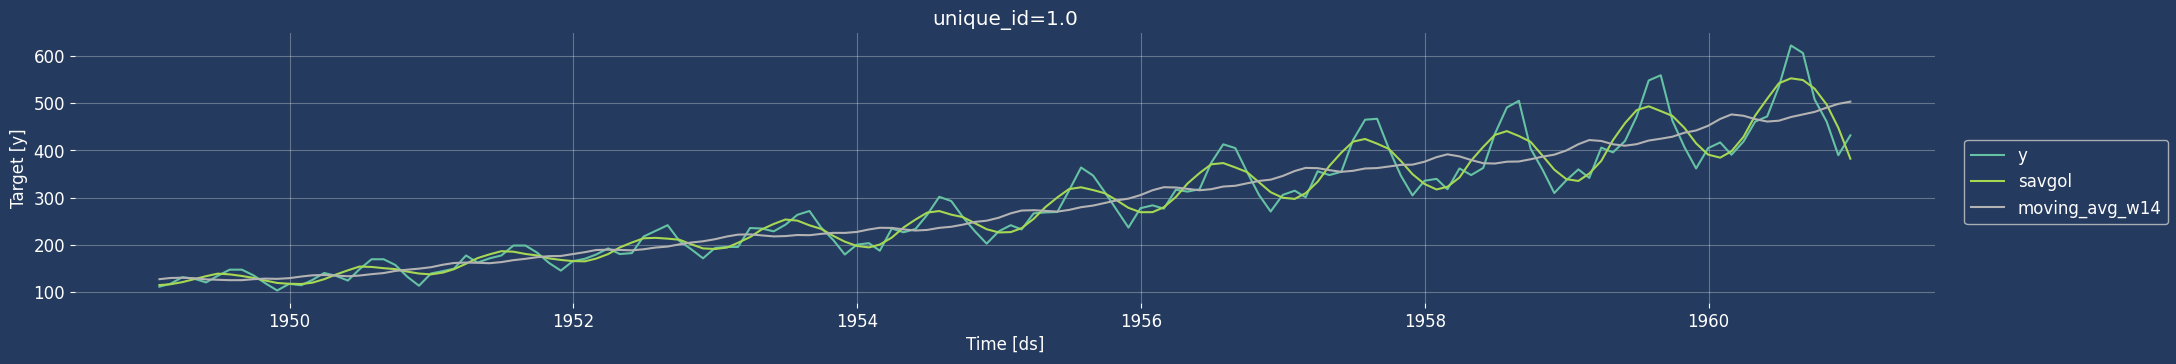

In [18]:
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter

def auto_filter_sizes(df):
    min_length = df.groupby('unique_id').size().min()
    
    # Use smaller fractions of the data length
    savgol_window = max(3, min(min_length // 10, 11))  # Changed from 5 to 10, max from 21 to 11
    moving_avg_window = max(2, min(min_length // 10, 14))  # Changed from 10 to 20, max from 14 to 7
    
    # Ensure Savgol window length is odd
    savgol_window = savgol_window if savgol_window % 2 == 1 else savgol_window + 1
    
    return savgol_window, moving_avg_window

def apply_filters(df, filters):
    df = df.sort_values(['unique_id', 'ds'])
    
    for filter_name, filter_params in filters.items():
        if filter_params['type'] == 'savgol':
            df = df.groupby('unique_id').apply(lambda x: apply_savgol(x, **filter_params['params'])).reset_index(drop=True)
        elif filter_params['type'] == 'moving_avg':
            df = df.groupby('unique_id').apply(lambda x: apply_moving_average(x, **filter_params['params'])).reset_index(drop=True)
    
    return df

def apply_savgol(group, window_length, polyorder):
    group['savgol'] = savgol_filter(group['y'], window_length, polyorder)
    return group

def apply_moving_average(group, window_size):
    group[f'moving_avg_w{window_size}'] = group['y'].rolling(window=window_size, center=True, min_periods=1).mean()
    return group

# Automatically determine filter sizes
savgol_window, moving_avg_window = auto_filter_sizes(df)

# Define the filters you want to apply
filters = {
    'savgol': {'type': 'savgol', 'params': {'window_length': savgol_window, 'polyorder': 3}},
    'moving_avg': {'type': 'moving_avg', 'params': {'window_size': moving_avg_window}}
}

# Apply the filters
df_filtered = apply_filters(df, filters)

# Prepare the DataFrame for plotting
columns_to_plot = ['savgol', f'moving_avg_w{moving_avg_window}']
df_to_plot = df_filtered[['unique_id', 'ds'] + columns_to_plot]

# Plot the results
palette = 'Set2'  # or any other palette you prefer


# Print the window sizes for verification
print(f"Savitzky-Golay window size: {savgol_window}")
print(f"Moving average window size: {moving_avg_window}")

plot_series(df, df_to_plot, palette=palette)

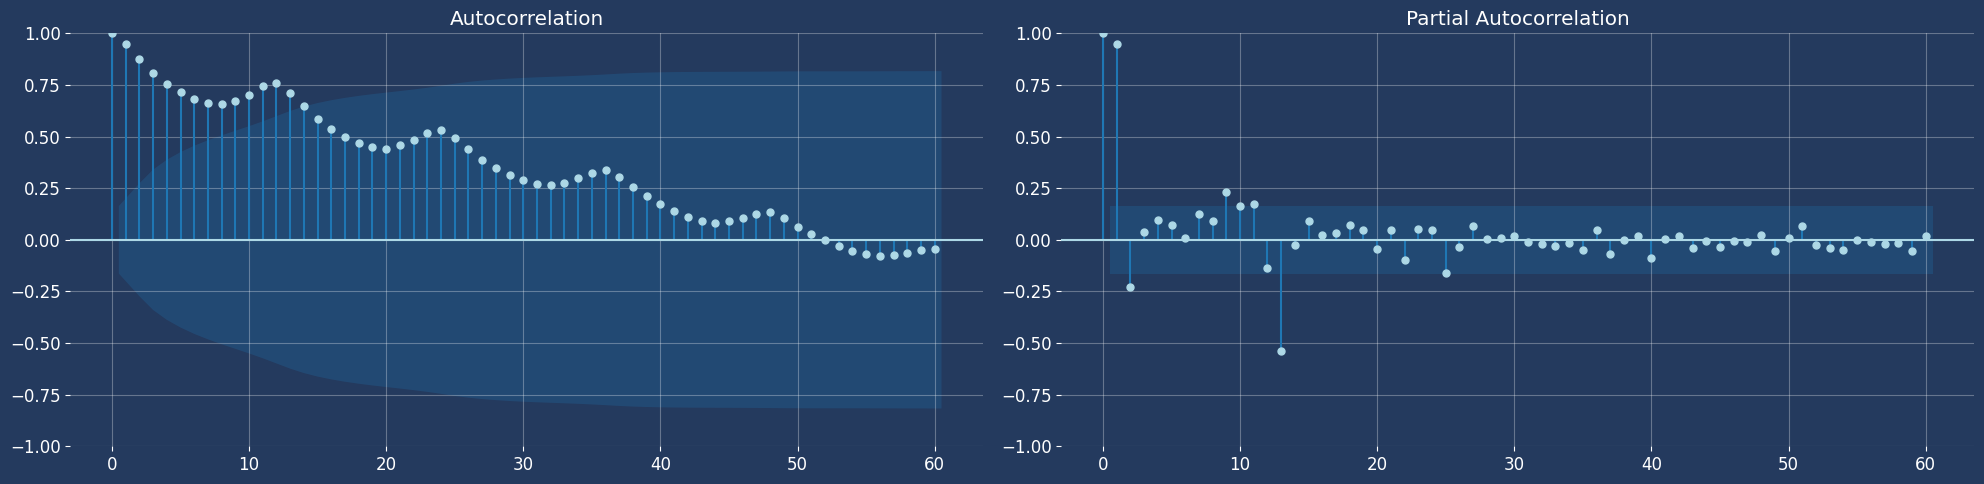

In [19]:
# ACF and PACF plots
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

plot_acf(df["y"], lags=60, ax=axs[0], color="lightblue")
axs[0].set_title("Autocorrelation", color='white')
axs[0].set_facecolor('#243A5E')

plot_pacf(df["y"], lags=60, ax=axs[1], color="lightblue")
axs[1].set_title('Partial Autocorrelation', color='white')
axs[1].set_facecolor('#243A5E')

for ax in axs:
    ax.grid(True, color='white', alpha=0.3)
    ax.set_xlabel(ax.get_xlabel(), color='white')
    ax.set_ylabel(ax.get_ylabel(), color='white')

plt.tight_layout()
plt.show()


In [38]:
from statsforecast.models import MSTL
models = [MSTL(season_length=12)]

sf = StatsForecast(df=df,
                   models=models,
                   freq='ME', 
                   n_jobs=-1)

sf.fit()

result=sf.fitted_[0][0].model_
result


,data,trend,seasonal,remainder
0,112.0,122.887635,-16.520519,5.632884
1,118.0,123.426488,-16.804821,11.378333
2,132.0,124.043281,7.793800,0.162919
3,129.0,124.726699,-0.949714,5.223014
4,121.0,125.457816,-3.649246,-0.808569
...,...,...,...,...
139,606.0,482.361703,94.494247,29.144050
140,508.0,486.124943,20.675851,1.199206
141,461.0,489.870213,-28.389534,-0.480679
142,390.0,493.532483,-76.056694,-27.475789


array([<Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

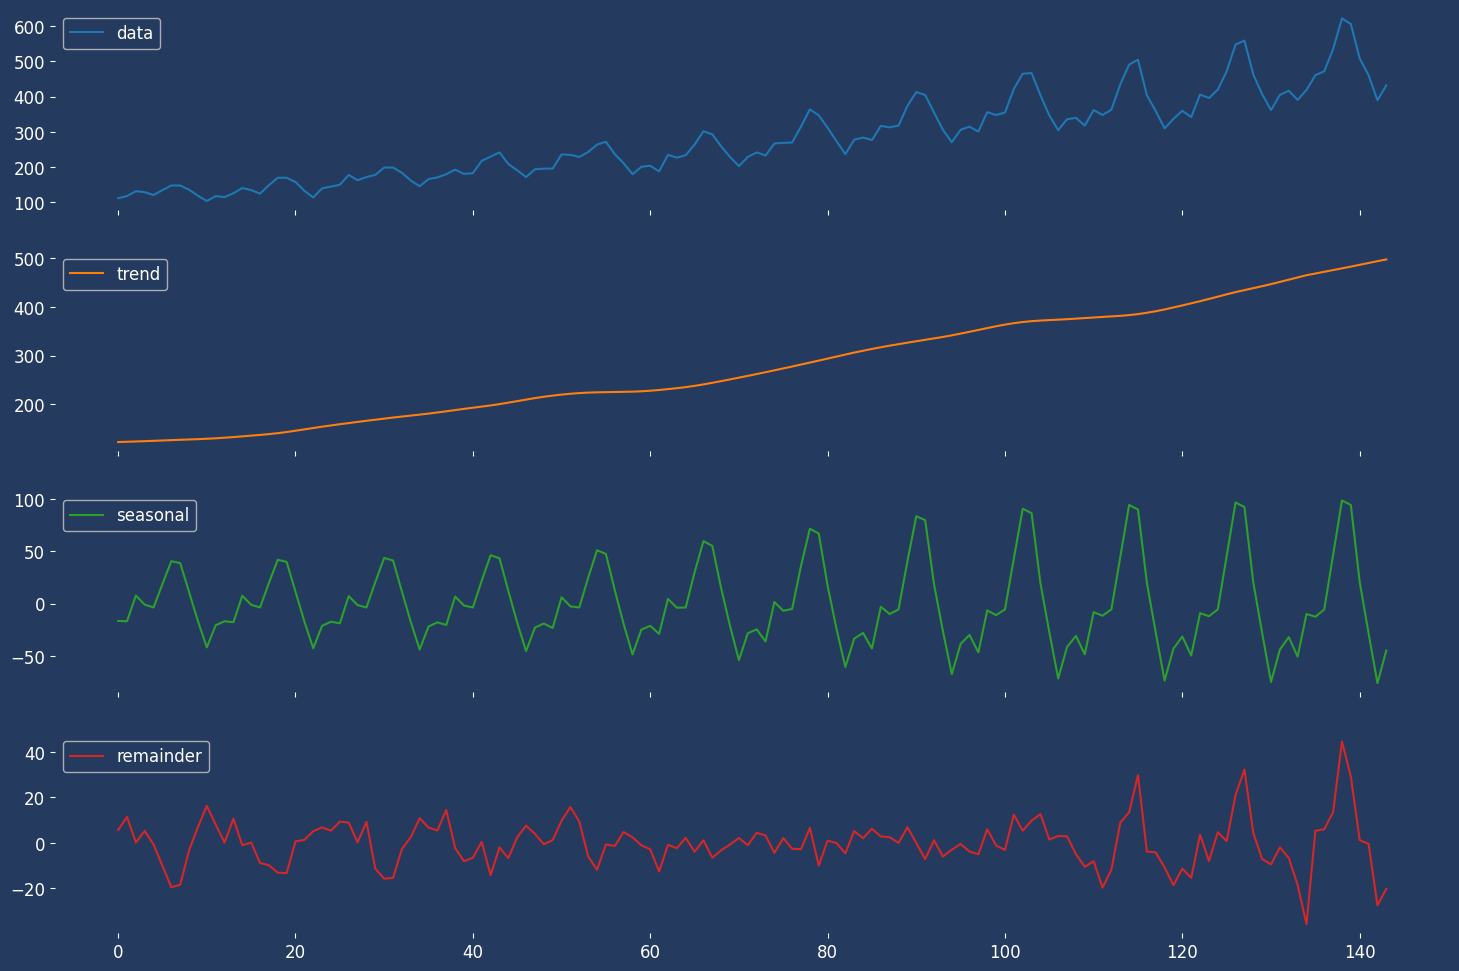

In [40]:
sf.fitted_[0,0].model_.plot(subplots = True, figsize=(18, 12))

Inferred/User-defined frequency: M

Insights for Unique_ID 1.0:
ADF Statistic: 0.8154
p-value: 0.9919
Non-stationary

Possible seasonalities detected:
  - Monthly (lag 1): ACF value = 0.948
  - Quarterly (lag 3): ACF value = 0.807
  - Yearly (lag 12): ACF value = 0.760

Strongest periodic patterns:
  - Lag 12: ACF value = 0.760
  - Lag 24: ACF value = 0.532
  - Lag 36: ACF value = 0.337


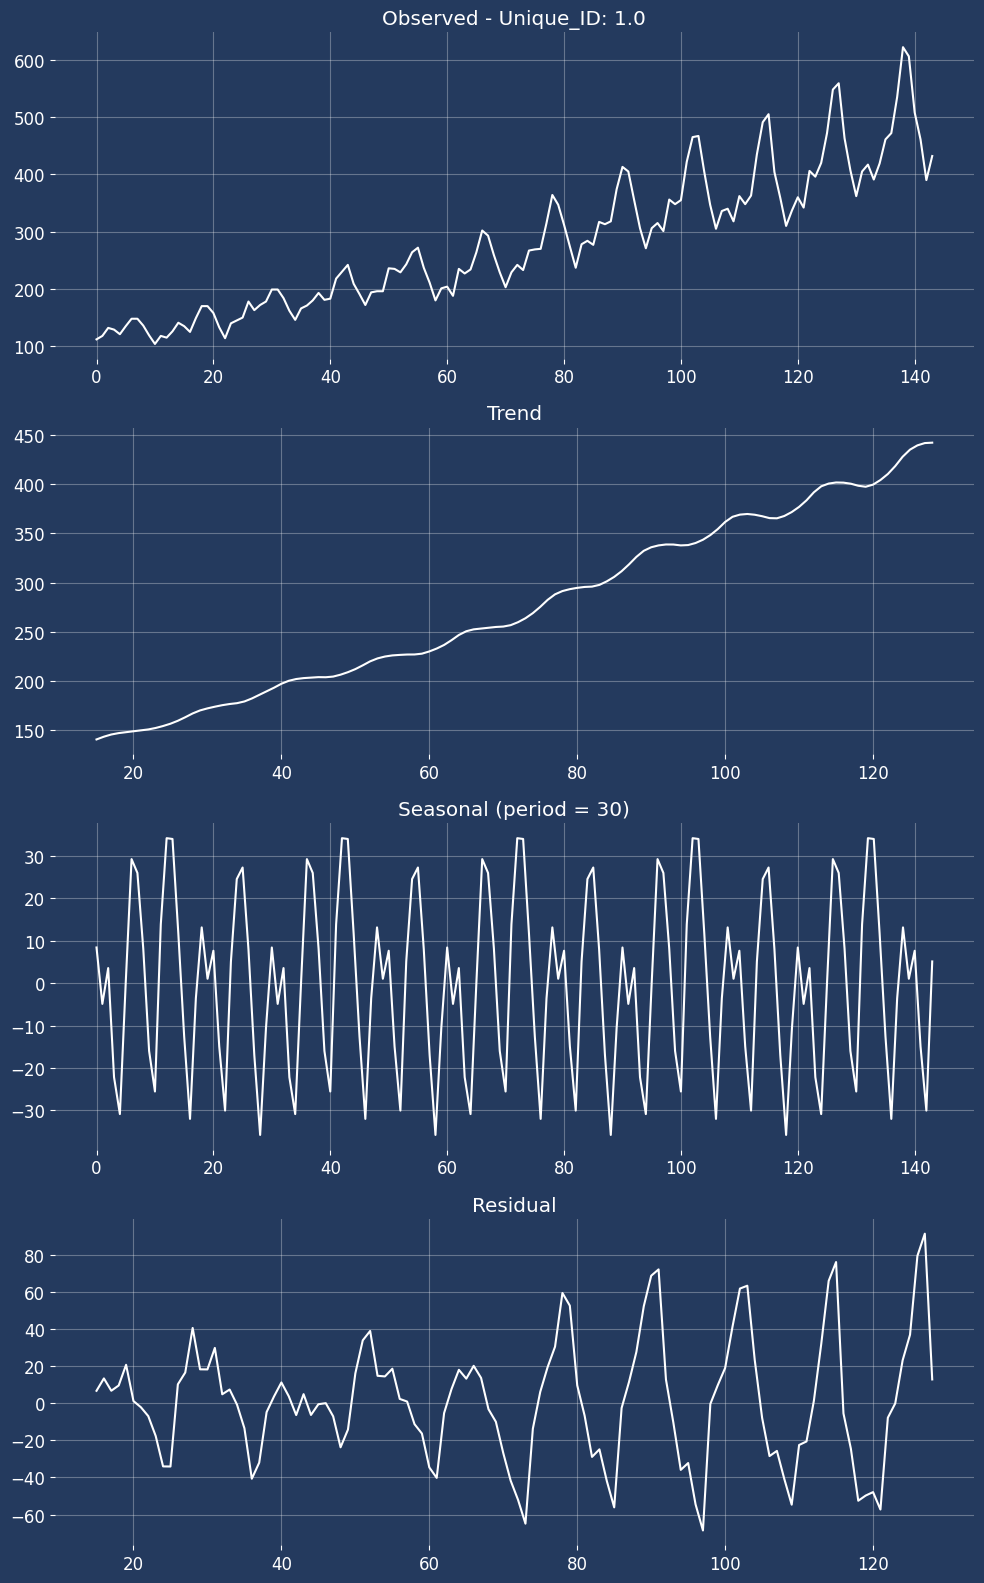

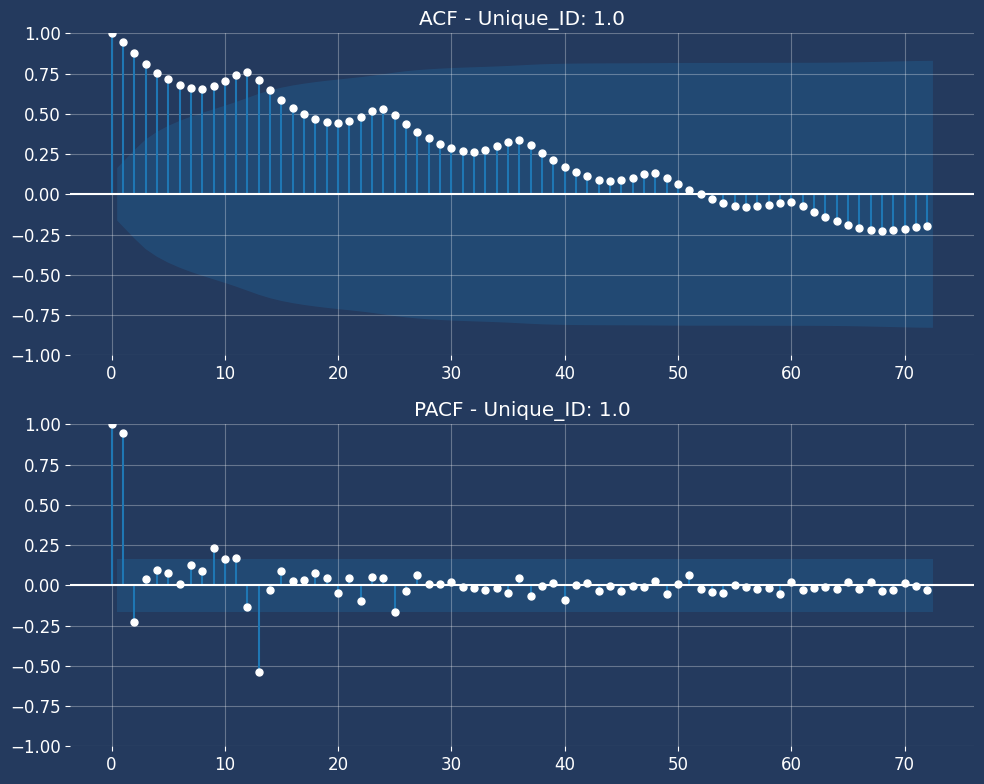

In [41]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.signal import find_peaks
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

def infer_frequency(df):
    if pd.api.types.is_datetime64_any_dtype(df['ds']):
        freq = pd.infer_freq(df['ds'])
        if freq is None:
            diff = df['ds'].diff().median()
            if diff.days == 1:
                return 'D'
            elif 28 <= diff.days <= 31:
                return 'M'
            elif 90 <= diff.days <= 92:
                return 'Q'
            elif 365 <= diff.days <= 366:
                return 'Y'
            else:
                return 'Unknown'
        else:
            freq_map = {'D': 'D', 'M': 'M', 'Q': 'Q', 'Y': 'Y', 'A': 'Y'}
            return freq_map.get(freq[0], 'Unknown')
    else:
        return 'Unknown'

def get_seasonalities(freq):
    seasonalities = {
        'D': {'Daily': 1, 'Weekly': 7, 'Biweekly': 14, 'Monthly': 30, 'Quarterly': 90, 'Yearly': 365},
        'M': {'Monthly': 1, 'Quarterly': 3, 'Yearly': 12},
        'Q': {'Quarterly': 1, 'Yearly': 4},
        'Y': {'Yearly': 1},
        'Unknown': {}
    }
    return seasonalities.get(freq, {})

def check_seasonality(data, freq, max_lag):
    seasonalities = get_seasonalities(freq)
    acf_values = acf(data, nlags=max_lag)[1:]  # Exclude lag 0
    
    peaks, _ = find_peaks(acf_values, height=0.1, distance=1)
    peak_values = acf_values[peaks]
    sorted_peaks = sorted(zip(peak_values, peaks + 1), reverse=True)
    
    detected_seasonalities = []
    for name, lag in seasonalities.items():
        if lag <= max_lag and abs(acf_values[lag-1]) > 0.1:
            detected_seasonalities.append((name, lag, acf_values[lag-1]))
    
    return detected_seasonalities, sorted_peaks

def perform_seasonal_decomposition(data, period):
    try:
        decomposition = seasonal_decompose(data, model='additive', period = period)
        return decomposition
    except ValueError as e:
        print(f"Error in seasonal decomposition: {e}")
        return None

def plot_decomposition(decomposition, uid, decomposition_period):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 16))
    
    decomposition.observed.plot(ax=ax1, color='white')
    ax1.set_title(f"Observed - Unique_ID: {uid}")
    ax1.grid(True, color='white', alpha=0.3)
    
    decomposition.trend.plot(ax=ax2, color='white')
    ax2.set_title("Trend")
    ax2.grid(True, color='white', alpha=0.3)
    
    decomposition.seasonal.plot(ax=ax3, color='white')
    ax3.set_title(f"Seasonal (period = {decomposition_period})")
    ax3.grid(True, color='white', alpha=0.3)
    
    decomposition.resid.plot(ax=ax4, color='white') 
    ax4.set_title("Residual")
    ax4.grid(True, color='white', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def print_insights(df, user_defined_freq=None):
    unique_ids = df['unique_id'].unique()
    
    if user_defined_freq:
        freq = user_defined_freq
    else:
        freq = infer_frequency(df)
    
    print(f"Inferred/User-defined frequency: {freq}")
    
    for uid in unique_ids:
        data = df[df['unique_id'] == uid]['y']
        
        # Automatically determine the number of lags based on data length
        max_lag = min(int(len(data) / 2), 100)  # Use half the data length, but cap at 100
        
        print(f"\nInsights for Unique_ID {uid}:")
        
        # Check for stationarity
        adf_result = adfuller(data)
        print(f"ADF Statistic: {adf_result[0]:.4f}")
        print(f"p-value: {adf_result[1]:.4f}")
        print("Stationary" if adf_result[1] < 0.05 else "Non-stationary")
        
        # Check for seasonality
        detected_seasonalities, sorted_peaks = check_seasonality(data, freq, max_lag)
        
        if detected_seasonalities:
            print("\nPossible seasonalities detected:")
            for name, lag, acf_value in detected_seasonalities:
                print(f"  - {name} (lag {lag}): ACF value = {acf_value:.3f}")
        else:
            print("\nNo strong evidence of common seasonalities")
        
        if sorted_peaks:
            print(f"\nStrongest periodic patterns:")
            for value, lag in sorted_peaks[:3]:  # Report top 3 peaks
                print(f"  - Lag {lag}: ACF value = {value:.3f}")
        else:
            print("\nNo significant peaks found in ACF")
        

        if freq == 'M':
            decomposition_period = 30
        elif freq == 'Q':
            decomposition_period = 30*3
        elif freq == 'Y':
            decomposition_period = 365
        else:
            decomposition_period = 7

        decomposition = perform_seasonal_decomposition(data, decomposition_period)
        if decomposition:
            plot_decomposition(decomposition, uid, decomposition_period)
        
        # Plot ACF and PACF
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
        plot_acf(data, lags=max_lag, ax=ax1, color='white')
        ax1.set_title(f"ACF - Unique_ID: {uid}")
        ax1.grid(True, color='white', alpha=0.3)
        
        pacf_results = plot_pacf(data, lags=max_lag, ax=ax2, method='ywm', color='white')
        ax2.set_title(f"PACF - Unique_ID: {uid}")
        ax2.grid(True, color='white', alpha=0.3)
        
        plt.tight_layout()
        plt.show()
# Usage
# If you know the frequency, you can specify it:
# print_insights(df, user_defined_freq='M')

# If you want the function to try to infer the frequency:
print_insights(df)